# Rats Sightings in Manhattan NYC

## Modeling
---
Author: _Zhan Yu_

We are using SARIMAX model which is a time series model incorporating Seasonality "S"and eXogenous features"X". The exogenous features are the number of restaurants and population based on zip code. 

## Table of Contents
- [Loading Libraries & Data](#Loading-Libraries-&-Data)
- [Modeling](#Modeling)
    - [ACF & PACF](#ACF-&-PACF)
    - [ARIMA](#ARIMA)
    - [SARIMAX](#SARIMAX)
- [Conclusion](#Conclusion)

## Loading Libraries & Data

In [86]:
# Libraries: 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA, ARMA, AR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import warnings
warnings.simplefilter(action="ignore")

%matplotlib inline

In [2]:
df = pd.read_csv('../datasets/exogenous.csv')
df.shape

## Modeling

### ACF & PACF

ACF & PACF will give us a general idea for selecting $P$ and $q$ later in ARIMA.

In [5]:
zip_10002 =df.loc[df['zip_code']==10002]

zip_10002['year_month']=pd.to_datetime(zip_10002['year_month'])

zip_10002.set_index('year_month',inplace = True)
zip_10002 = zip_10002.astype(int)
zip_10002.head()

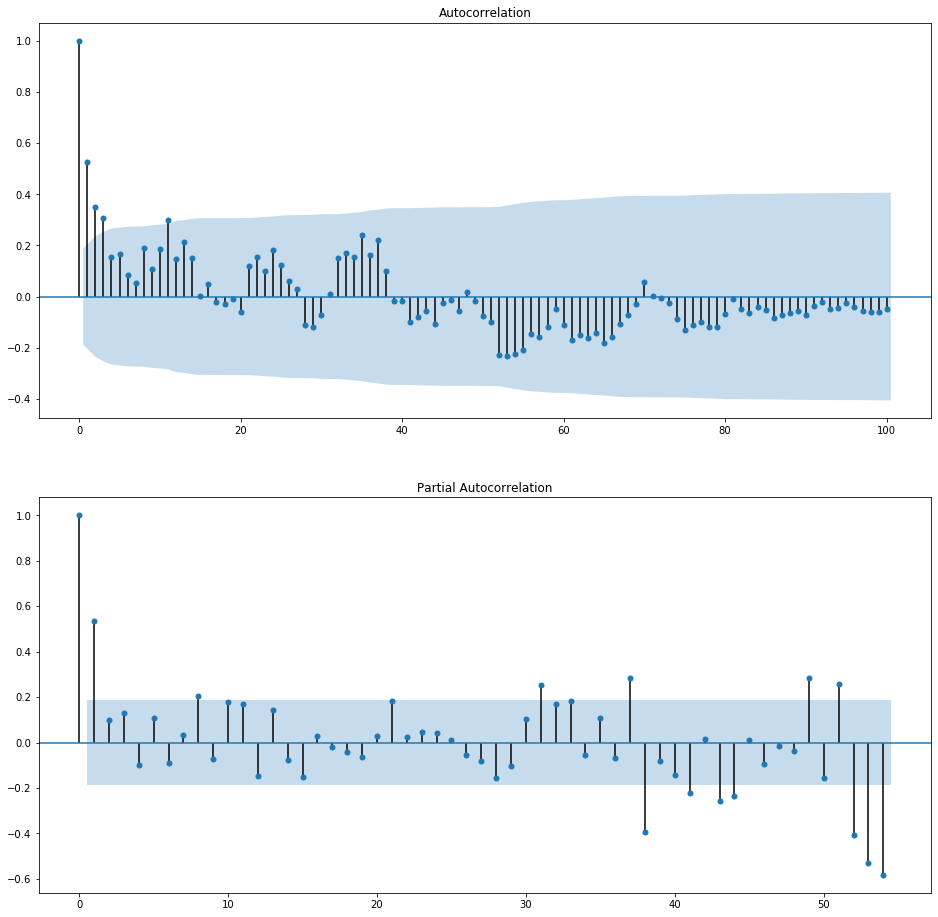

In [27]:
# First half of 108 months' Autocorr and Partial Autocorr
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(211)
fig = plot_acf(zip_10002['sighting'], lags = 54, ax = ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(zip_10002['sighting'], lags = 54, ax = ax2);

We are going to split our data to training data from January, 2010 to December, 2016 and testing data from January, 2017 to December, 2018.

In [239]:
train = zip_10002[['sighting']].iloc[:84,]
test = zip_10002[['sighting']].iloc[84:,]

train_res = zip_10002[['restaurant']].iloc[:84,]
test_res = zip_10002[['restaurant']].iloc[84:,]

train_pop = zip_10002[['population']].iloc[:84,]
test_pop = zip_10002[['population']].iloc[84:,]

exog_train = pd.concat([train_res, train_pop], axis = 1)
exog_test = pd.concat([test_res, test_pop], axis = 1)

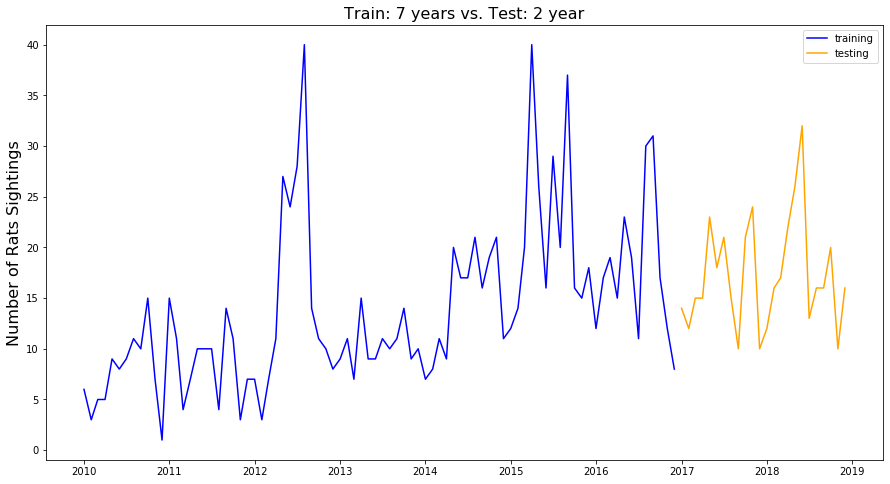

In [314]:
# Plot data.
plt.figure(figsize=(15, 8))
plt.plot(train.index, train, color = 'blue', label = 'training')   # Plot training data.
plt.plot(test.index, test, color = 'orange', label = 'testing')    # Plot testing data.
plt.title(label = 'Train: 7 years vs. Test: 2 year', fontsize=16)
plt.ylabel('Number of Rats Sightings', fontsize=16)
plt.legend(loc='best')
plt.show();

In [315]:
# Define a function for plotting:
def train_test_pred_plot(train, test, pred, title):
    plt.figure(figsize=(15, 8))                                        # Set size
    plt.plot(train.index, train, color = 'blue', label = 'training')   # Plot training data.
    plt.plot(test.index, test, color = 'orange', label = 'testing')    # Plot testing data. 
    plt.plot(test.index, pred, color = 'green', label = 'prediction')  # Plot predicted test values.
    plt.title(label = title, fontsize=16)                              # The lable of our plot
    plt.ylabel('Number of Rats Sightings', fontsize=16)
    plt.legend(loc='best')
    plt.show();

### ARIMA

#### Checking for Stationarity: the Augmented Dickey-Fuller Test

The [augmented Dickey-Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) is a hypothesis test that tests for stationarity. We assume that our data are not stationary. With enough evidence, we may accept that our data are stationary.

The test is as follows:

$$
\begin{eqnarray}
&H_0:& \text{not stationary} \\
&H_A:& \text{stationary}
\end{eqnarray}
$$

In [203]:
# Code written by Joseph Nelson (from our note)
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

interpret_dftest(adfuller(zip_10002['sighting']))

Test Statistic   -5.737
p-value           0.000
dtype: float64

$p$-value 0.000 gives us evidence to reject the null hypothesis, meaning we accept that our time series is stationary.

#### Manual GridSearch

Since we have $d = 0$, we can manually search $p$ and $q$.

In [293]:
# Starting AIC, p, and q.
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0

# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for q in range(5):
        
        # Insert try and except statements.
        try:
            
            # Fitting an ARIMA(p, 0, q) model.
            print(f'Attempting to fit ARIMA({p},0,{q})')
            
            # Instantiate ARIMA model.
            arima = ARIMA(endog = Z_train.astype(float).dropna(), # endog = Y variable
                          order = (p,0,q)) # values of p, d, q
            
            # Fit ARIMA model.
            model = arima.fit()

            # Print out AIC for ARIMA(p, 0, q) model.
            print(f'The AIC for ARIMA({p},0,{q}) is: {model.aic}')

            # Is my current model's AIC better than our best_aic?
            if model.aic < best_aic:
                
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = model.aic
                best_p = p
                best_q = q

        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},0,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

Attempting to fit ARIMA(0,0,0)
The AIC for ARIMA(0,0,0) is: 276.4361983752972
Attempting to fit ARIMA(0,0,1)
The AIC for ARIMA(0,0,1) is: 252.26745383972434
Attempting to fit ARIMA(0,0,2)
The AIC for ARIMA(0,0,2) is: 253.3732734121975
Attempting to fit ARIMA(0,0,3)
The AIC for ARIMA(0,0,3) is: 246.23462489163919
Attempting to fit ARIMA(0,0,4)
The AIC for ARIMA(0,0,4) is: 247.7655311473013
Attempting to fit ARIMA(1,0,0)
The AIC for ARIMA(1,0,0) is: 245.98992233675642
Attempting to fit ARIMA(1,0,1)
The AIC for ARIMA(1,0,1) is: 246.22903377431055
Attempting to fit ARIMA(1,0,2)
Attempting to fit ARIMA(1,0,3)
The AIC for ARIMA(1,0,3) is: 246.612044082372
Attempting to fit ARIMA(1,0,4)
Attempting to fit ARIMA(2,0,0)
The AIC for ARIMA(2,0,0) is: 246.9177653455003
Attempting to fit ARIMA(2,0,1)
The AIC for ARIMA(2,0,1) is: 249.86117102888483
Attempting to fit ARIMA(2,0,2)
The AIC for ARIMA(2,0,2) is: 246.97233112426042
Attempting to fit ARIMA(2,0,3)
The AIC for ARIMA(2,0,3) is: 248.13150418798

In [295]:
# Our model that minimizes AIC on the training data is the ARIMA(3,0,2):
ARMA3_2 = ARIMA(endog = train.astype(float).dropna(),
                order = (3, 0, 2))
model = ARMA3_2.fit()

In [296]:
pred_train_arma = ARMA3_2.predict(params = model.params,
                         start = train.index[0],
                         end = train.index[-1])
pred_test_arma = ARMA3_2.predict(params = model.params,
                        start = test.index[0],
                        end = test.index[-1])

MSE for training data is 35.34611739680965
MSE for testing data is 50.41891577691367


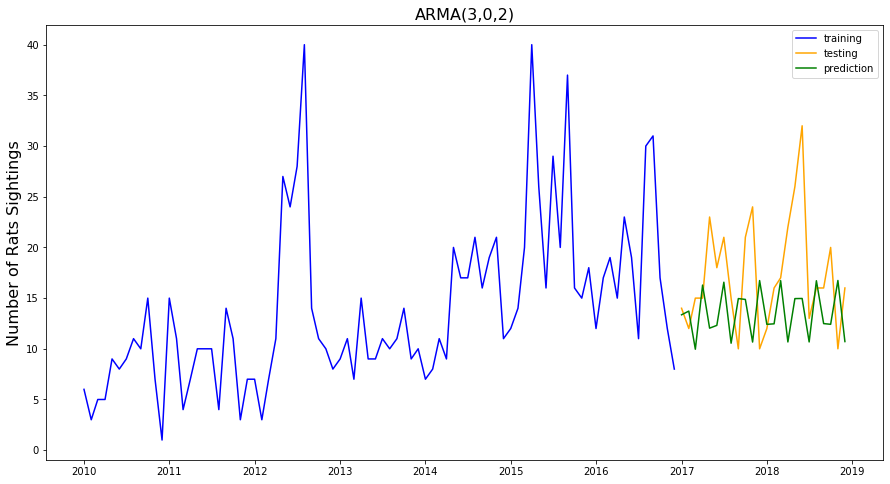

In [316]:
mse_train = mean_squared_error(train, pred_train_arma)
mse_test = mean_squared_error(test, pred_test_arma)
print(f'MSE for training data is {mse_train}')
print(f'MSE for testing data is {mse_test}')

preds = pd.DataFrame(pred_test_arma, index = test.index, columns = ['sighting'])
train_test_pred_plot(train, test, pred = preds, title = 'ARMA(3,0,2)')

As we can see, our prediction shows seasonality, but our model does not perform very good with ARIMA.

### SARIMAX

Since our model does not perform very good with ARIMA, we will introduce Seasonality "S"and two eXogenous features"X". First we are going to manually GridSearch $p$, $d$, $q$, $S$, $P$, $D$ and $Q$, the baseline for our model is when $p$, $d$, $q$, $S$, $P$, $D$ and $Q$ are all 0:

In [ ]:
import time
t0 = time.time()
final_mse = 10000000000000
final_D = 0
final_P = 0
final_Q = 0

for p in range(3):
    for d in range(4):
        for q in range(4):
            for P in range(3):
                for D in range(3):
                    for Q in range(3):
                        for S in [0,37,38]:
                            print(f'Checking ({p}, {d}, {q}) x ({P},{D},{Q},{S}) at {round(time.time() - t0)} seconds.')
                            try:
                                sarimax = SARIMAX(endog = train.dropna(),
                                                 exog = exog_train.dropna(),
                                                 order = (p,d,q),
                                                 seasonal_order = (P,D,Q,S)).fit()

                                sarimax_pred = sarimax.predict(start = test.index[0], end = test.index[-1],
                                                               exog = exog_test.dropna())
                                mse = mean_squared_error(test, sarimax_pred)

                                if mse < final_mse:
                                    final_mse = mse
                                    final_d = d
                                    final_p = p
                                    final_q = q
                                    final_PDQS = (P,D,Q,S)

                                print(f'We just fit a SARIMAX({p,d,q})x({P},{D},{Q},{S}) model with {mse} MSE.')

                            except:
                                pass

print(f'The final model is SARIMAX{final_p, final_d, final_q}x{final_PDQS} model with {final_mse} MSE.')

The final model is SARIMAX(1, 1, 0)x(2, 0, 0, 37) model with 22.081851209986493 MSE.(Too long to show in GitHub)

In [298]:
sarimax = SARIMAX(endog = train.dropna(),
                  exog = exog_train.dropna(),
                  order = (1, 1, 0),
                  seasonal_order = (2, 0, 0, 37)).fit()

sarimax_pred_train = sarimax.predict(start = train.index[0], 
                                     end = train.index[-1],
                                     exog = exog_train.dropna())

sarimax_pred_test = sarimax.predict(start = test.index[0], 
                                    end = test.index[-1],
                                    exog = exog_test.dropna())

preds_train = pd.DataFrame(sarimax_pred_train.values, 
                           index=train.index, columns = ['sighting'])

preds_test = pd.DataFrame(sarimax_pred_test.values, 
                          index=test.index, columns = ['sighting'])

In [321]:
mse_train = mean_squared_error(train[1:], sarimax_pred_train[1:])
mse_test = mean_squared_error(test, sarimax_pred_test)
print(f'MSE for training data is {mse_train}')
print(f'MSE for testing data is {mse_test}')

MSE for training data is 48.89391617619334
MSE for testing data is 22.081851209986493


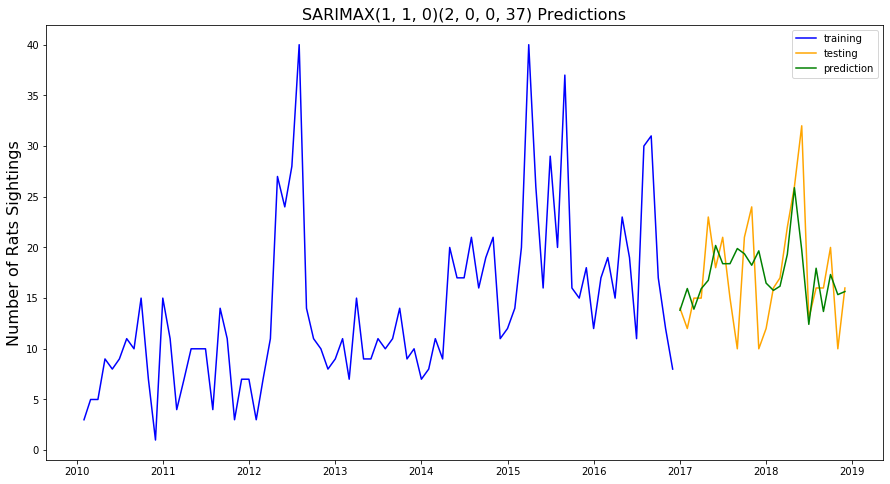

In [318]:
train_test_pred_plot(train[1:], test, pred = preds_test, title = 'SARIMAX(1, 1, 0)(2, 0, 0, 37) Predictions')

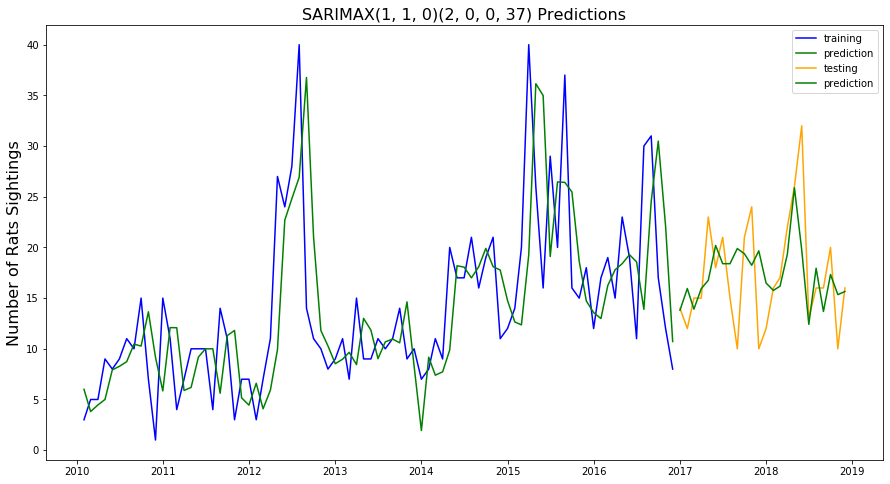

In [319]:
# Plot all.
plt.figure(figsize=(15, 8))
plt.plot(train.index[1:], train[1:], color = 'blue', label = 'training')    # Plot training data.
plt.plot(train.index[1:], preds_train[1:], color = 'green', label = 'prediction')  # Plot predicted train values.
plt.plot(test.index, test, color = 'orange', label = 'testing')      # Plot testing data.
plt.plot(test.index, preds_test, color = 'green', label = 'prediction')     # Plot predicted test values.
plt.title(label = 'SARIMAX(1, 1, 0)(2, 0, 0, 37) Predictions', fontsize=16)
plt.ylabel('Number of Rats Sightings', fontsize=16)
plt.legend(loc='best')
plt.show();

In [325]:
print(f'RMSE for training data is {mse_train**0.5}')
print(f'RMSE for testing data is {mse_test**0.5}')

RMSE for training data is 6.99241847833733
RMSE for testing data is 4.699133027483526


We can say our prediction has less than 5 sightings error from root mean squared error(RMSE).

## Conclusion

From the root mean squared error(RMSE), overall we can say that our model performs well. This time series model to predict rats sightings for one zip code area NY 10002 can also be applied to all zip codes in NYC.